In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import dataset

In [2]:
import os
from scipy.io import wavfile

In [3]:
data_path = 'data_cat_dog/cats_dogs'
files = os.listdir(data_path)

df = pd.DataFrame(columns = ['rate', 'sound', 'animal', 'file'])
i=0
for file in files:
    if file != 'train' and file != 'test':
        rate, sound = wavfile.read(data_path + "/" + file)
        animal = 'cat' if 'cat' in file else 'dog'
        # doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
        df.loc[i] = [rate, sound, animal, file]
        i += 1

# Explore dataset

In [4]:
df.head()

,rate,sound,animal,file
0,16000,"[124, 107, 7, -22, -64, -51, -27, -64, -137, -...",cat,cat_1.wav
1,16000,"[-8, 0, 4, -13, -11, -9, -7, -14, -19, -22, 5,...",cat,cat_10.wav
2,16000,"[-257, -275, -254, -288, -198, -140, -180, -11...",cat,cat_100.wav
3,16000,"[-79, -140, -131, 139, 289, 232, 172, 208, 152...",cat,cat_101.wav
4,16000,"[-206, -55, 120, 43, -123, -235, -324, -293, -...",cat,cat_102.wav


In [5]:
len(df)

277

In [6]:
print(np.unique(df.rate)) # all the files have the same sample rate
sample_rate = 16000 # so let's define this variable

[16000]


In [7]:
df.sound.apply(len).apply(
    [max, min]
)
# the files have different size -> different duration

max    287616
min     14773
Name: sound, dtype: int64

In [8]:
# adding column duration
df['duration'] = df.sound.apply(len) / df.rate

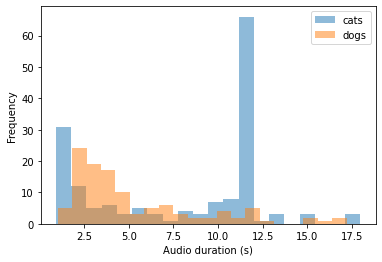

0.9233125
17.976


In [9]:
df[df.animal=='cat'].duration.plot.hist(bins=20, alpha = 0.5, label = 'cats')
df[df.animal=='dog'].duration.plot.hist(bins=20, alpha = 0.5, label = 'dogs')
plt.xlabel("Audio duration (s)")
plt.legend()
plt.show()
print(min(df.duration))
print(max(df.duration))

<AxesSubplot:>

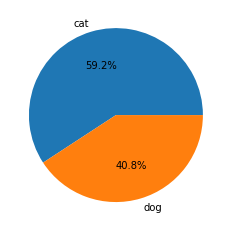

In [10]:
df[['animal', 'file']].groupby('animal').count().plot.pie(
    y='file', legend=False, xlabel='', ylabel='', autopct='%1.1f%%')
# dataset no está muy descompensado

# Plot sounds

tienen diferente duración cada audio, pero en cada audio suelen haber varios maullidos/ladridos -> se pueden cortar los audios en fragmentos más cortos y que siempre haya algún sonido en ellos

In [12]:
def plotSounds(rows):
    for row in rows:
        y = df.loc[row, 'sound']
        duration = df.loc[row, 'duration']
        time_axis = np.linspace(0, duration, len(y))
        label = df.loc[row, 'file']
        #label = f"Patient {df.loc[row, 'patient']}, {df.loc[row, 'diagnosis_multi']}"
        plt.plot(time_axis, list(y), label = label, alpha=0.5)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

observamos que los perros tienen en general chillidos mas cortos y que se repiten varias veces, mientras que los gatos tienen un maullido más largo

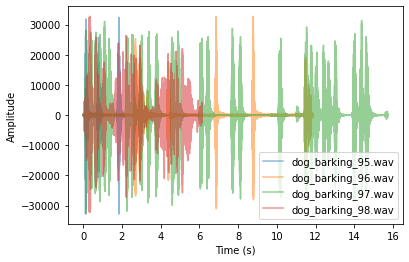

In [13]:
plotSounds([272,273,274,275])

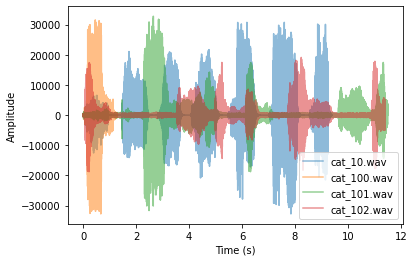

In [14]:
plotSounds([1,2,3,4])
#plotSounds([3])

# Split train-test

se observa que el train set y el test set tienen mas o menos, la misma distribución que el dataset original (y la misma entre ellos) acerca de el ratio cats-dogs y de las duraciones de audios. si fueran muy diferentes habría problemas

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
test_size = 0.3

df_train, df_test = train_test_split(df, test_size=test_size, random_state=1)

<AxesSubplot:>

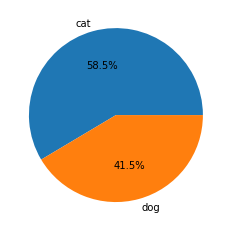

In [17]:
df_train[['animal', 'file']].groupby('animal').count().plot.pie(
    y='file', legend=False, xlabel='', ylabel='', autopct='%1.1f%%')

<AxesSubplot:>

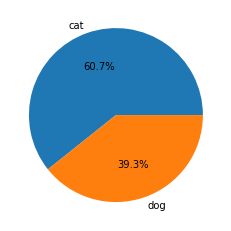

In [18]:
df_test[['animal', 'file']].groupby('animal').count().plot.pie(
    y='file', legend=False, xlabel='', ylabel='', autopct='%1.1f%%')

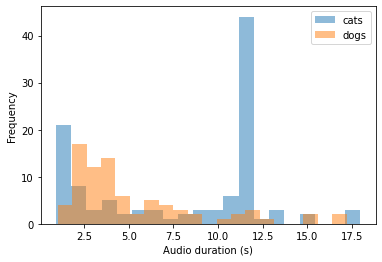

In [19]:
df_train[df_train.animal=='cat'].duration.plot.hist(bins=20, alpha = 0.5, label = 'cats')
df_train[df_train.animal=='dog'].duration.plot.hist(bins=20, alpha = 0.5, label = 'dogs')
plt.xlabel("Audio duration (s)")
plt.legend()
plt.show()

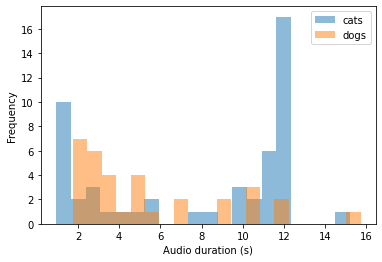

In [20]:
df_test[df_test.animal=='cat'].duration.plot.hist(bins=20, alpha = 0.5, label = 'cats')
df_test[df_test.animal=='dog'].duration.plot.hist(bins=20, alpha = 0.5, label = 'dogs')
plt.xlabel("Audio duration (s)")
plt.legend()
plt.show()

# Split sounds in multiple shorter sounds

to apply the fourier transform and using certain frequencies to train, it is necessary that all the sounds have the same length

train set: i am cutting all the sounds in pieces of 3s (it is enough to contain an animal sound)
- if a sound is less than 3s, i drop it
- if it is longer than 6s, i can include two pieces of itinclude it twice
- if it is longer than 9s, i can have three clips of the original sound
- etc.

test set: i will also need the audios to have the same duration to the ones of training the model
- if a sound is shorter than 3s -> drop it -> that will be a limitation of the model
    - another option would be to fill it with a blank sound until reaching the 3s
- for instances longer than 6s, i would have multiple samples of the same sound, so i can "test multiple times" and select the animal with larger overall probability -> the longer is a sample, the better the model can predict (i expect)

In [21]:
max_duration = 3

In [22]:
def soundSplitter(s, max_duration):
    max_length = max_duration * sample_rate
    if len(s) < max_length:
        return []
    return [s[0:max_length]] + soundSplitter(s[max_length:], max_duration)

In [23]:
# example:
print(df.duration[0])
soundSplitter( df.sound[0], 3)


11.2


[array([  124,   107,     7, ...,  -761, -1027, -1221], dtype=int16),
 array([-1303, -1341, -1221, ...,  -495,   924,  2193], dtype=int16),
 array([2703, 2400, 1952, ...,  161,  230,  316], dtype=int16)]

## refactor train set and test set

in the test set do the same than in the train set

(in both cases), keep a column with the id (filename) of the original audio. then, after evaluating the test set, i can group by filename and sum the probabilities of each file

In [26]:
def splitAudiosDf(old_df, max_duration):
    new_df = pd.DataFrame(columns=['rate', 'sound', 'animal', 'file', 'clip_id'])
    i=0
    for row in old_df.index:
        clips = soundSplitter(df.loc[row, 'sound'], max_duration)
        for clip in clips:
            new_df.loc[i, 'rate'] = old_df.loc[row, 'rate']
            new_df.loc[i, 'sound'] = clip
            new_df.loc[i, 'animal'] = old_df.loc[row, 'animal']
            new_df.loc[i, 'file'] = old_df.loc[row, 'file']
            new_df.loc[i, 'clip_id'] = i
            i = i+1
    return new_df

    

In [27]:
df_train2 = splitAudiosDf(df_train, max_duration)
df_test2 = splitAudiosDf(df_test, max_duration)


see also how the number of videos for the train set has increased, although shorter -> better model (?)

In [28]:
len(df_train)

193

In [29]:
len(df_train2)

357

# Transformation to time-frequency domain

i perform stft to the signals. since all of them have the same length, the output of all of them has the same dimensions and consists in the same frequencies and time moments

stft stands for short time fourier transform. it is an algorithm that applies fourier transforms (fft) to small time windows, so we have the frequencies along time, resulting in 2d-plots time-freq-amplitude, that we can interpret as images

In [30]:
import librosa
import librosa.display

In [32]:
def melTransform(clip):
    return librosa.amplitude_to_db(np.abs(librosa.stft(clip*1.0)), ref=np.max)

def melTransformMulti(clip_list):
    return np.array([
        melTransform(np.array(clip)) for clip in clip_list
    ])


(1025, 94)


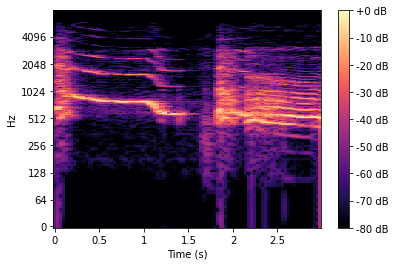

In [61]:
# example of the stft transformation:
# - with a longer audio clip:
sound = df_train.sound[df_train.index[0]]*1.0 # (*1.0 because it needs float, not int)
# - with a shortened clip:
sound = df_train2.sound[df_train2.index[0]]*1.0
sound_tf = librosa.amplitude_to_db(np.abs(librosa.stft(sound)), ref=np.max)
librosa.display.specshow(sound_tf, sr=rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (s)")
print(sound_tf.shape)


Text(0, 0.5, 'Amplitude')

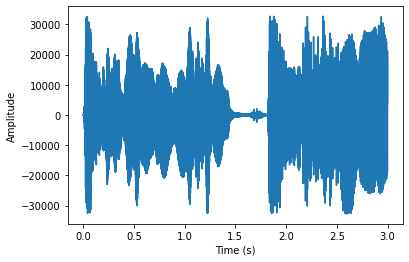

In [62]:
# the same image as above, but with a time dependent chart
y = df_train2.loc[0, 'sound']
duration = len(y)/rate
time_axis = np.linspace(0, duration, len(y))
plt.plot(time_axis, list(y))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

In [35]:
df_train_mel = melTransformMulti(df_train2.sound)
df_train_mel.shape

(357, 1025, 94)

In [36]:
df_test_mel = melTransformMulti(df_test2.sound)
df_test_mel.shape

(154, 1025, 94)

# Model building and training

In [37]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [39]:
# cnn model
# some convolution layers (combine nearby 'pixels')
# then a couple of dense layers (the normal neural network)

model = tf.keras.models.Sequential([
    # convolution 1
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(1025, 94, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #convolution 2
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # convolution 3
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # convolution 4
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
x_train = np.expand_dims(df_train_mel, axis=-1)
x_test = np.expand_dims(df_test_mel, axis=-1)
y_train = tf.keras.utils.to_categorical(np.array(df_train2.animal == "cat")) # positive class = cat; negative class = dog
y_test = tf.keras.utils.to_categorical(np.array(df_test2.animal == "cat"))

In [41]:
model.fit(x_train, y_train, batch_size=32,epochs=100, validation_split=0.2)

Epoch 1/100
9/9 [==============================] - 22s 2s/step - loss: 22.5888 - accuracy: 0.4807 - val_loss: 0.5173 - val_accuracy: 0.7917
Epoch 2/100
9/9 [==============================] - 18s 2s/step - loss: 0.6239 - accuracy: 0.7053 - val_loss: 0.5530 - val_accuracy: 0.7917
Epoch 3/100
9/9 [==============================] - 19s 2s/step - loss: 0.6251 - accuracy: 0.6947 - val_loss: 0.5161 - val_accuracy: 0.7917
Epoch 4/100
9/9 [==============================] - 18s 2s/step - loss: 0.6409 - accuracy: 0.7053 - val_loss: 0.5823 - val_accuracy: 0.7917
Epoch 5/100
9/9 [==============================] - 18s 2s/step - loss: 0.6166 - accuracy: 0.7053 - val_loss: 0.5292 - val_accuracy: 0.7917
Epoch 6/100
9/9 [==============================] - 18s 2s/step - loss: 0.6099 - accuracy: 0.7053 - val_loss: 0.5321 - val_accuracy: 0.7917
Epoch 7/100
9/9 [==============================] - 18s 2s/step - loss: 0.6004 - accuracy: 0.7053 - val_loss: 0.5295 - val_accuracy: 0.7917
Epoch 8/100
9/9 [=========

save the model & load a saved model, to avoid the training time

In [42]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [43]:
model2 = tf.keras.models.load_model('model')

# Evaluation of the model

In [48]:
# predicted values
yh_train = model.predict(x_train)
yh_test = model.predict(x_test)

5/5 [==============================] - 2s 480ms/step


In [49]:
# confusion matrix
print(confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(yh_test, axis=1)
))
print('\n')
print(confusion_matrix(
    np.argmax(y_train, axis=1),
    np.argmax(yh_train, axis=1)
))

[[36  6]
 [14 98]]


[[ 96   3]
 [ 22 236]]


In [50]:
# accuracy
accuracy_train = model.evaluate(x_train, y_train)
accuracy_test = model.evaluate(x_test, y_test)
print(accuracy_train)
print(accuracy_test)

5/5 [==============================] - 2s 484ms/step - loss: 0.4298 - accuracy: 0.8701
[0.33880025148391724, 0.9299719929695129]
[0.42983582615852356, 0.8701298832893372]


0.9119897959183674


Text(0, 0.5, 'True positive rate')

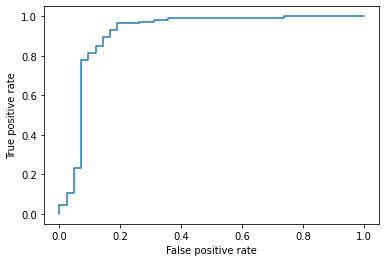

In [52]:
# roc curve
fpr, tpr, thresholds = roc_curve(y_test[:,1], yh_test[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
